In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [4]:
series = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 0 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values

In [6]:
series2 = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values2 = series2.values

In [7]:
series3 = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 2 average.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values3 = series3.values

In [7]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [8]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [9]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### For Cluster 0

In [10]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


2024-05-13 09:58:29.909486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 09:58:30.028283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-05-13 09:58:30.028347: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-13 09:58:30.029661: I tensorflow/core/platform/cpu_feature_guard.cc:193] 

44/44 [==============================] - 0s 1ms/step


array([[ 0.06648806],
       [-0.13855046],
       [ 0.58086413],
       [-0.34507522],
       [ 0.1112348 ],
       [-0.26291683],
       [-0.22074142],
       [-0.26897588],
       [-0.7135774 ],
       [-0.13431743],
       [ 0.48980737],
       [-0.17330042],
       [-0.19262615],
       [ 0.05023268],
       [-0.4131585 ],
       [-0.59892106],
       [-0.68222404],
       [-0.28113434],
       [ 0.6061725 ],
       [-0.3002716 ],
       [-0.30592272],
       [ 0.23911619],
       [-0.45751902],
       [-0.22906324],
       [-0.1371612 ],
       [ 0.25512117],
       [-0.45591125],
       [-0.7180816 ],
       [ 0.09254724],
       [-0.5569793 ],
       [-0.2806838 ],
       [ 0.16854341],
       [-0.42447868],
       [-0.33208886],
       [-0.42915675],
       [-0.3613445 ],
       [ 0.36861444],
       [-0.43487397],
       [-0.17400572],
       [-0.59601915],
       [ 0.0868623 ],
       [ 0.2355819 ],
       [-0.45891723],
       [-0.5456735 ]], dtype=float32)

In [11]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 15ms/step
Month=1, Predicted=1372.322699, Expected=1381.566106
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=1376.816210, Expected=1374.486594
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=1374.512826, Expected=1378.116427


Test RMSE: 5.884


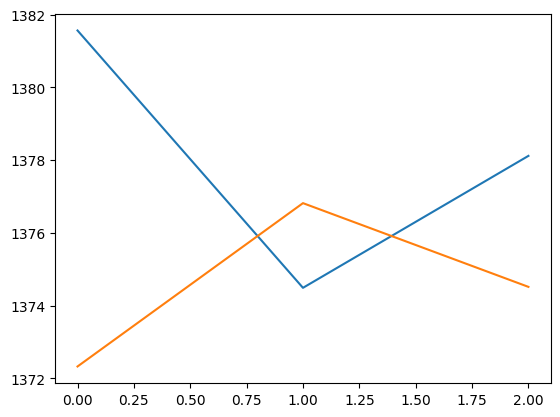

In [12]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [13]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 940us/step


array([[-0.18593436],
       [-0.4538347 ],
       [ 0.01349358],
       [ 0.17337568],
       [-0.30873087],
       [ 0.01991861],
       [-0.31131735],
       [ 0.19337116],
       [-0.09058732],
       [-0.06445093],
       [ 0.26223546],
       [ 0.2903731 ],
       [-0.14909385],
       [ 0.10289362],
       [ 0.44569004],
       [ 0.09217104],
       [ 0.25578582],
       [ 0.11195408],
       [ 0.18935405],
       [ 0.20296727],
       [ 0.21598656],
       [-0.24932535],
       [-0.28710514],
       [-0.08739151],
       [-0.15239108],
       [ 0.2530964 ],
       [ 0.30284697],
       [-0.0531031 ],
       [-0.15321876],
       [ 0.28358895],
       [ 0.7397135 ],
       [-0.01562321],
       [ 0.19886695],
       [-0.10337614],
       [ 0.01360467],
       [-0.268562  ],
       [-0.3795053 ],
       [ 0.5874769 ],
       [ 0.02668594],
       [-0.17509665],
       [ 0.43456024],
       [ 0.0757473 ],
       [-0.14302208],
       [ 0.33470994]], dtype=float32)

In [14]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=275.788499, Expected=275.539862
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=275.741124, Expected=274.678387
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=275.676638, Expected=275.965119


Test RMSE: 0.652


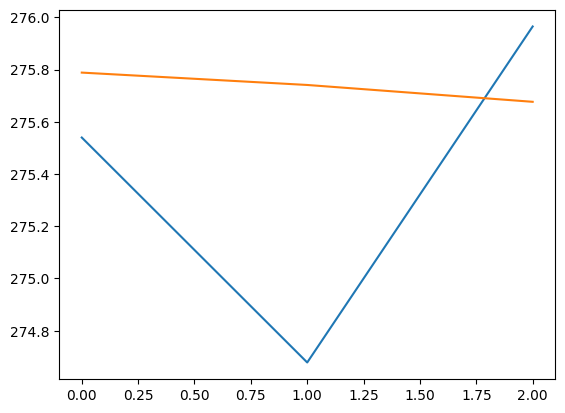

In [15]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [16]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 852us/step


array([[-0.13639782],
       [-0.17532466],
       [-0.01307125],
       [-0.24303083],
       [-0.40798682],
       [-0.380022  ],
       [ 0.10035902],
       [-0.30672926],
       [ 0.10902463],
       [ 0.23231444],
       [ 0.0539327 ],
       [-0.3016271 ],
       [-0.46090394],
       [-0.17329921],
       [-0.3414402 ],
       [-0.20142429],
       [ 0.3458513 ],
       [-0.07297826],
       [-0.26895136],
       [ 0.32031655],
       [-0.11042106],
       [ 0.28940463],
       [-0.16755609],
       [ 0.39354652],
       [ 0.00830705],
       [ 0.14595805],
       [-0.09604484],
       [-0.23985605],
       [-0.41382265],
       [-0.34823215],
       [-0.34554577],
       [ 0.38433772],
       [-0.02979107],
       [-0.36745512],
       [-0.32131672],
       [-0.32881242],
       [-0.0994366 ],
       [-0.33294827],
       [ 0.00091771],
       [-0.15485777],
       [ 0.19414386],
       [-0.1933919 ],
       [-0.40470815],
       [-0.20974241]], dtype=float32)

In [17]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 17ms/step
Month=1, Predicted=2992.313039, Expected=3001.920000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2995.560401, Expected=3009.820800
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=3000.089606, Expected=2997.898600


Test RMSE: 10.008


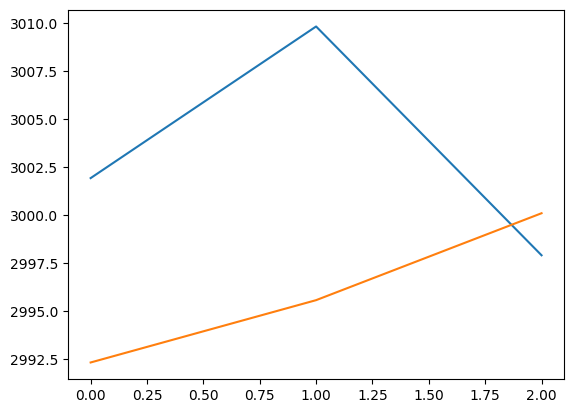

In [18]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()